[View in Colaboratory](https://colab.research.google.com/github/neoaksa/HPC/blob/master/2.Bio%20Crystal%20Growth/bioCrystal.ipynb)

The 3D bio-Crystal is generate by C++, which you can find [here](https://https://github.com/neoaksa/HPC/blob/master/2.Bio%20Crystal%20Growth/Biological%20Crystal%20Growth.cc)

The output is [a csv file](https://github.com/neoaksa/HPC/blob/master/2.Bio%20Crystal%20Growth/example.csv) which marks the points of bio-crystal in the 3D space(300 \* 300 \* 300).

This notebook is used only for visualization.

**Step 1**: Download and read csv file from github

In [11]:
# !pip install -q xlrd
# clone git
!rm -r HPC
!git clone https://github.com/neoaksa/HPC.git

    
# Files from the cloned git repository.
!ls HPC/"2.Bio Crystal Growth"

import pandas as pd
header = ["x","y","z"]
df = pd.read_csv('HPC/2.Bio Crystal Growth/crystal.csv',index_col=None, header=None, usecols=[0,1,2], names=header)
df.head(10)
df.count()

Cloning into 'HPC'...
remote: Counting objects: 197, done.
remote: Total 197 (delta 0), reused 0 (delta 0), pack-reused 197
Receiving objects: 100% (197/197), 582.41 KiB | 810.00 KiB/s, done.
Resolving deltas: 100% (72/72), done.
bioCrystal.ipynb	   Biological Crystal Growth.cc  crystal.csv  Readme.md
Biological Crystal Growth  Biological Crystal Growth.o	 example.csv


x    269
y    269
z    269
dtype: int64

**Step 2:** Create a 3D lattice and visualize from df

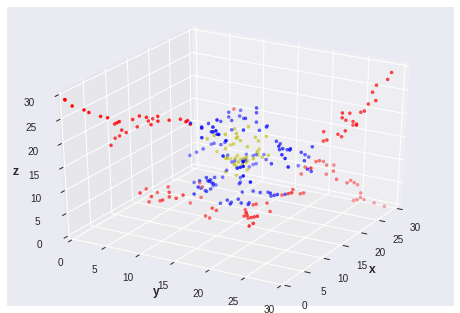

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
# setting label for axis rather plot
ax.set_xlabel('x',size=12,fontweight='semibold') 
ax.set_ylabel('y',size=12,fontweight='semibold') 
ax.set_zlabel('z',size=12,fontweight='semibold') 
# size of lattice
x_size = 30
y_size = 30
z_size = 30
# set range of axis
ax.set_xlim(0,x_size)
ax.set_ylim(0,y_size)
ax.set_zlim(0,z_size)
# invert x axis
ax.invert_xaxis()
# set color by distance to center
df['dist'] = np.sqrt(np.square(df['x']-(int)(x_size/2))
                     + np.square(df['y']-(int)(y_size/2)) 
                     + np.square(df['z']-(int)(z_size/2)))
col = np.where(df['dist'].between(0,5,inclusive=True) ,'y',np.where(df['dist'].between(5,10,inclusive=False)  ,'b','r'))
# set view angle
ax.scatter(df['x'], df['y'], df['z'], s=10, color=col)
ax.view_init(30, 30)
plt.show()
